In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init("spark-2.4.4-bin-hadoop2.7")
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
import pyspark.sql as sparksql
sc = spark.sparkContext

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
workdir = '/content/gdrive/My Drive/IFABI-2019/Data Science - Project 03/data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np

In [0]:
train = spark.read.csv(workdir + 'train_2v.csv', inferSchema=True,header=True)
test = spark.read.csv(workdir + 'test_2v.csv', inferSchema=True,header=True)

In [0]:
# fill in missing values for smoking status
# As this is categorical data, we will add one data type "No Info" for the missing one
train_f = train.na.fill('No Info', subset=['smoking_status'])
test_f = test.na.fill('No Info', subset=['smoking_status'])

In [0]:
# fill in miss values for bmi 
# as this is numecial data , we will simple fill the missing values with mean
from pyspark.sql.functions import mean
mean = train_f.select(mean(train_f['bmi'])).collect()
mean_bmi = mean[0][0]
train_f = train_f.na.fill(mean_bmi,['bmi'])
test_f = test_f.na.fill(mean_bmi,['bmi'])

In [0]:
# indexing all categorical columns in the dataset
from pyspark.ml.feature import StringIndexer
indexer1 = StringIndexer(inputCol="gender", outputCol="genderIndex")
indexer2 = StringIndexer(inputCol="ever_married", outputCol="ever_marriedIndex")
indexer3 = StringIndexer(inputCol="work_type", outputCol="work_typeIndex")
indexer4 = StringIndexer(inputCol="Residence_type", outputCol="Residence_typeIndex")
indexer5 = StringIndexer(inputCol="smoking_status", outputCol="smoking_statusIndex")

In [0]:
# Doing one hot encoding of indexed data
from pyspark.ml.feature import OneHotEncoderEstimator
encoder = OneHotEncoderEstimator(inputCols=["genderIndex","ever_marriedIndex","work_typeIndex","Residence_typeIndex","smoking_statusIndex"],
                                 outputCols=["genderVec","ever_marriedVec","work_typeVec","Residence_typeVec","smoking_statusVec"])

In [0]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['genderVec',
 'age',
 'hypertension',
 'heart_disease',
 'ever_marriedVec',
 'work_typeVec',
 'Residence_typeVec',
 'avg_glucose_level',
 'bmi',
 'smoking_statusVec'],outputCol='features')

In [0]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, indexer5, encoder, assembler])

In [0]:
train_i = pipeline.fit(train_f).transform(train_f)

In [0]:
n_clusters = 5
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=n_clusters, seed=13)  
model = kmeans.fit(train_i.select('features'))

In [15]:
transformed = model.transform(train_i)
transformed.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+-----------------+--------------+-------------------+-------------------+---------------+-------------+-----------------+-------------+-----------------+--------------------+----------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|genderIndex|ever_marriedIndex|work_typeIndex|Residence_typeIndex|smoking_statusIndex|ever_marriedVec|    genderVec|smoking_statusVec| work_typeVec|Residence_typeVec|            features|prediction|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----------+-----------------+--------------+-------------------+-------------------+---------------+-------------+-----------------+-------------+-----------------+--------------------+----------+
|306

In [0]:
transformed.createOrReplaceTempView('table')

In [0]:
c = spark.sql("SELECT stroke, prediction, genderIndex, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status FROM table")
df = c.toPandas()

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

def compare_features_in_clusters_continous(df, feature, n_clusters):
  for i in range(n_clusters):
    bins = np.linspace(50,200,150)
    x = df[feature][np.where(df['prediction'] == i)[0]]
    plt.hist(x, bins, alpha=0.5, label=i)
  plt.legend()
  plt.show()

def compare_features_in_clusters_category(df, feature, n_clusters, n_category):
  all_clusters = []
  for i in range(n_clusters):
    cluster = [df[df.prediction == i][['prediction', feature]].groupby(feature).count()['prediction'][j] for j in range(n_category)]
    all_clusters.append(cluster)
  r = np.arange(n_clusters)
  b = np.array([v[0] for v in all_clusters])
  plt.bar(r, b)
  for i in range(1, n_category):
    plt.bar(r, [v[i] for v in all_clusters], bottom=b)
    b += [v[i] for v in all_clusters]


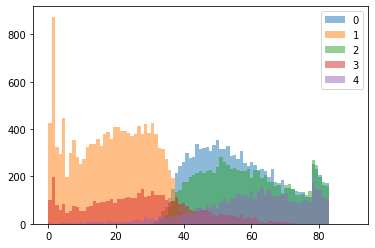

In [19]:
compare_features_in_clusters_continous(df, 'age', n_clusters)

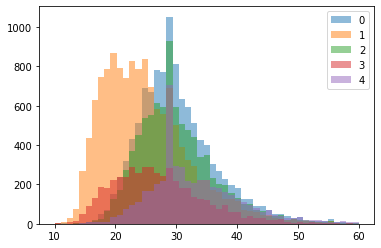

In [83]:
compare_features_in_clusters_continous(df, 'bmi', n_clusters)

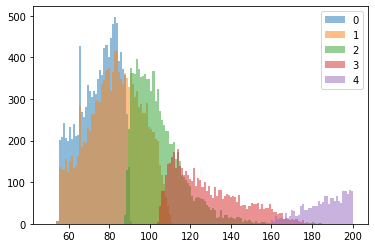

In [23]:
compare_features_in_clusters_continous(df, 'avg_glucose_level', n_clusters)

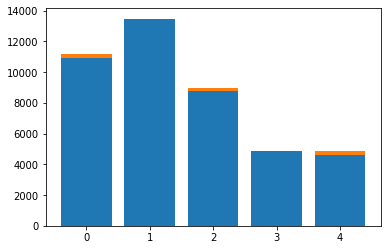

In [73]:
compare_features_in_clusters_category(df, 'stroke', n_clusters, 2)

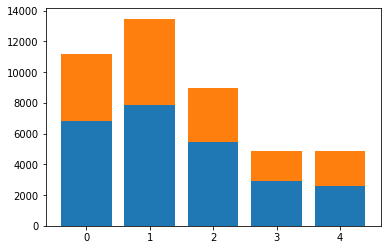

In [74]:
compare_features_in_clusters_category(df, 'genderIndex', n_clusters, 2)

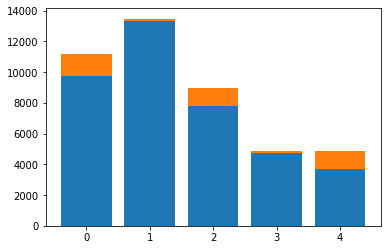

In [75]:
compare_features_in_clusters_category(df, 'hypertension', n_clusters, 2)

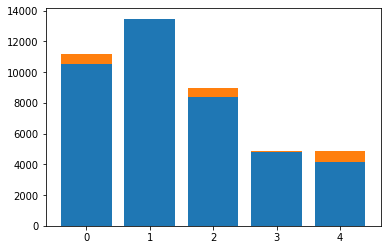

In [76]:
compare_features_in_clusters_category(df, 'heart_disease', n_clusters, 2)

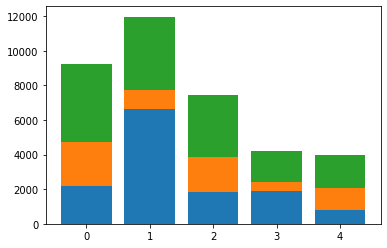

In [81]:
compare_features_in_clusters_category(df, 'smoking_status', n_clusters, 3)

In [0]:
n_clusters = 2
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=n_clusters, seed=13)  
model = kmeans.fit(train_i.select('features'))

In [0]:
transformed = model.transform(train_i)
transformed.createOrReplaceTempView('table')
c = spark.sql("SELECT stroke, prediction, genderIndex, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status FROM table")
df = c.toPandas()

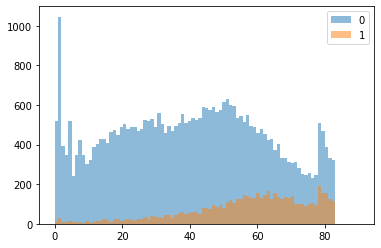

In [90]:
compare_features_in_clusters_continous(df, 'age', n_clusters)

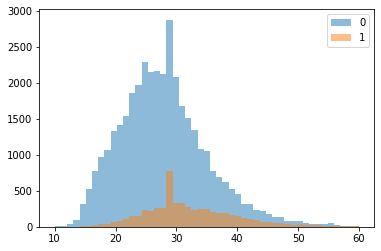

In [92]:
compare_features_in_clusters_continous(df, 'bmi', n_clusters)

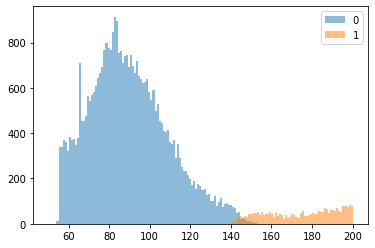

In [94]:
compare_features_in_clusters_continous(df, 'avg_glucose_level', n_clusters)

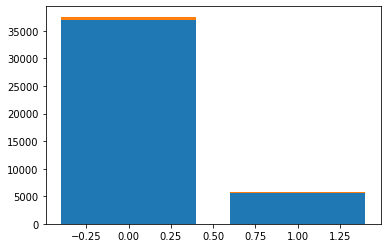

In [95]:
compare_features_in_clusters_category(df, 'stroke', n_clusters, 2)

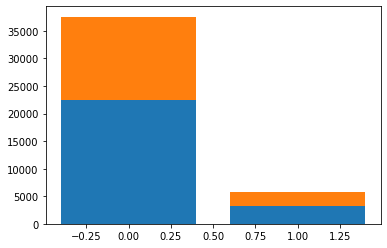

In [96]:
compare_features_in_clusters_category(df, 'genderIndex', n_clusters, 2)

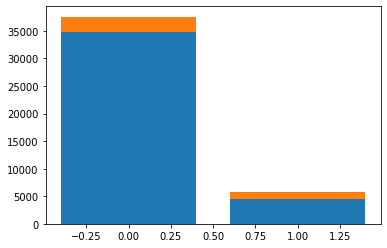

In [97]:
compare_features_in_clusters_category(df, 'hypertension', n_clusters, 2)

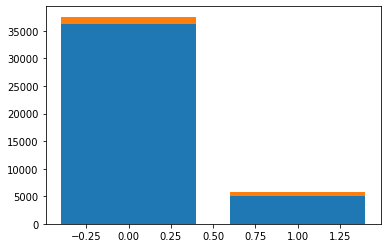

In [98]:
compare_features_in_clusters_category(df, 'heart_disease', n_clusters, 2)

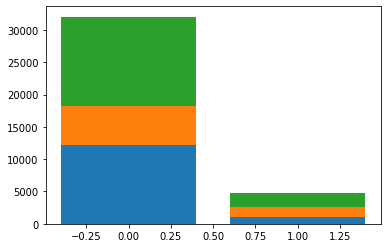

In [99]:
compare_features_in_clusters_category(df, 'smoking_status', n_clusters, 3)